深度学习区分猫狗图片程序

In [1]:
import cv2 # 机器视觉库，安装请用pip3 install opencv-python
import numpy as np # 数值计算库
import os # 系统库
from random import shuffle # 随机数据库 
from tqdm import tqdm # 输出进度库
import matplotlib.pyplot as plt # 常用画图库

In [2]:
train_dir = './train/'
test_dir = './test/'
img_size = 50
lr = 1e-3

将label变成每个类别的概率（类似于哑变量）

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

处理训练数据，大约需要30秒

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        if (not img.endswith('.jpg')):
            continue
        label = label_img(img)
        path = os.path.join(train_dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 读入灰度图
        img = cv2.resize(img, (img_size, img_size) )  # 将图片变成统一大小
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    return training_data
        

In [5]:
train_data = create_train_data()

100%|██████████| 25000/25000 [00:36<00:00, 686.02it/s]


处理测试数据，注意没有label信息

In [6]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        if (not img.endswith('.jpg')):
            continue
        path = os.path.join(test_dir,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    return testing_data

导入基于Tensorflow的高级深度学习库tflearn

In [7]:
import tflearn # 需要安装tensorflow，然后安装tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d  # 2维CNN以及最大采样
from tflearn.layers.core import input_data, dropout, fully_connected # 输入层，dropout，全连接层
from tflearn.layers.estimator import regression # cross entropy层

W0919 15:08:30.131558 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0919 15:08:30.132447 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0919 15:08:30.141307 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0919 15:08:30.145996 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0919 15:08:30.155790 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/t

注意：如果多次运行不同的网络结构图，每次需要先清空图

In [8]:
import tensorflow as tf
tf.reset_default_graph()

In [9]:
convnet = input_data(shape = [None, img_size, img_size, 1], name = 'input')

W0919 15:08:30.168632 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/layers/core.py:81: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



3个CNN及2个max pooling层

-- conv_2d(convnet, 32, 5, activation='relu')表示建立32个filter，每一个大小都是5x5xchannel。因为默认使用"SAME" padding,加了0使得每个点都可以对应filter左上角

-- max_pool_2d(convnet, 5)表示对于输出的每个5x5的区域求最大值

In [10]:
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

W0919 15:08:30.179275 4563932608 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tflearn/initializations.py:119: calling UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0919 15:08:30.180154 4563932608 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:507: UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
W0919 15:08:30.198189 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/layers/conv.py:552: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



两个全连接层与预测层

In [11]:
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate = lr, loss='categorical_crossentropy', name='targets')

W0919 15:08:30.248870 4563932608 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tflearn/initializations.py:174: calling TruncatedNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0919 15:08:30.271872 4563932608 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tflearn/layers/core.py:239: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0919 15:08:30.300074 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/optimizers.py:238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0919 15:08:30.307286

In [12]:
model = tflearn.DNN(convnet, tensorboard_dir='log')

W0919 15:08:30.364306 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/summaries.py:46: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0919 15:08:30.421719 4563932608 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0919 15:08:30.746621 4563932608 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/helpers/trainer.py:134: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



In [13]:
train = train_data[:-500]

In [14]:
test = train_data[-500:]

In [15]:
X = np.array([i[0] for i in train], dtype=np.float64).reshape(-1, img_size, img_size, 1)
y = np.array([i[1] for i in train], dtype=np.float64)
Xtest = np.array([i[0] for i in test], dtype=np.float64).reshape(-1, img_size, img_size, 1)
ytest = np.array([i[1] for i in test], dtype=np.float64)

在训练集上训练，无GPU大约需要2-3分钟

In [16]:
model.fit({'input': X}, {'targets': y}, n_epoch=3, validation_set=({'input': Xtest}, {'targets': ytest}), snapshot_step=500, show_metric=True, run_id='model' )

Training Step: 1148  | total loss: 0.46691 | time: 31.101s
| Adam | epoch: 003 | loss: 0.46691 - acc: 0.7826 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.46561 | time: 32.187s
| Adam | epoch: 003 | loss: 0.46561 - acc: 0.7856 | val_loss: 0.52803 - val_acc: 0.7480 -- iter: 24500/24500
--


读入测试数据，大约需要30秒

In [17]:
test_data = process_test_data()

100%|██████████| 12500/12500 [00:17<00:00, 697.53it/s]


输出测试数据上一些例子的预测

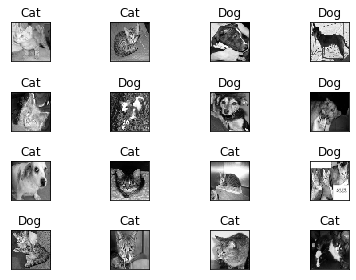

In [18]:
fig = plt.figure()
for num,data in enumerate(test_data[:16]):
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(img_size, img_size, 1)
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 1: 
        label = 'Dog'
    else: 
        label = 'Cat'
    
    y.imshow(orig, cmap='gray')
    plt.title(label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()